# CCGANs - Context-Conditional Generative Adversarial Networks

Brief introduction to Context-Conditional Generative Adversarial Networks or CCGANs. This notebook is organized as follows:

1. **Research Paper**
2. **Background**
3. **Definition**
4. **Training CCGANs with MNIST dataset, Keras and TensorFlow**


## 1. Research Paper

* [Semi-Supervised Learning with Context-Conditional Generative Adversarial Networks](https://arxiv.org/pdf/1611.06430.pdf)

## 2. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The value function $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$


## 3. Definition

Context-Conditional Generative Adversarial Networks (CC-GANs) are conditional GANs where the generator is trained to fill in a missing image patch and the generator and discriminator are conditioned on the surrounding pixels.

CC-GANs address a different task: determining if a part of an image is real or fake given the surrounding context.

The generator $G$ receives as input an image with a randomly masked out patch. The generator outputs an entire image.  We fill in the missing patch from the generated output and then pass the completed image into $D$.

### Network Design

<img src="../../img/network_design_cc_gan.png" width="600"> 


### Cost Funcion

$$
\begin{aligned}
    \underset{G}{min} \: \underset{D}{max} \; V_{CCGAN}(D,G) =& \mathbb{E}_{x\sim \mathcal{X}}[log D(x)] + \mathbb{E}_{x\sim \mathcal{X}, m\sim \mathcal{M}}[log(1 - D(x_I))] \\
    x_I =& (1 - m) \bigodot x_G + m \bigodot x \\
    x_G =& G(m \bigodot x, z)
\end{aligned}
$$

## 3. Training CCGANs with MINIST dataset, Keras and TensorFlow

CCGANs implementation using "U-net" model and convolutional neural network and the [Keras](https://keras.io/) library.

* **Data**
    * Rescale the MNIST images to be between -1 and 1.
    * Resize 32x32
    
* **Generator**
    * **U-net network**.
    * The input to the generator is the **normal distribution** $z$.
    * The last activation is **tanh**.
    
* **Discriminator**
    * **Convolutional neural network** and **LeakyReLU activation**.
    * The last activation is **softmax**.
    
* **Loss**
    * Discriminator: loss=['mse', 'categorical_crossentropy'].
    * Adversarial: loss=['mse']

* **Optimizer**
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 100

### 1. Load data

#### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import tensorflow as tf


2023-11-03 14:06:22.462469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 14:06:22.494958: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Getting the data

In [2]:
# load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()


#### Explore visual data

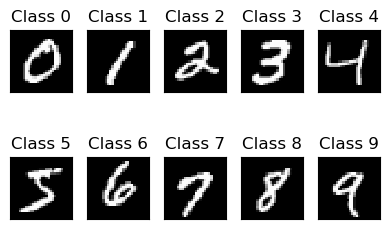

In [3]:
WIDTH_SIZE = 4
HEIGHT_SIZE = 3

fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()


#### Reshaping and normalizing the inputs

In [4]:
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)

if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

# y to categorical
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes+1)

print('X_train reshape:', X_train.shape)
print('y_train reshape:', y_train.shape)


X_train.shape (60000, 28, 28)
y_train.shape (60000,)
X_train reshape: (60000, 28, 28, 1)
X_train reshape: (60000, 28, 28, 1)
y_train reshape: (60000, 11)


In [5]:
X_train = ski.transform.resize(X_train, [X_train.shape[0], 32, 32, 1])
print('X_train reshape:', X_train.shape)


X_train reshape: (60000, 32, 32, 1)


### 2. Define model

#### Generator

In [6]:
# Number of filters in first layer of generator
gf = 32
k = 4
s = 2

# imagem shape 28x28x1
img_shape = X_train[0].shape

# Generator input
img_g = tf.keras.layers.Input(shape=(img_shape))

# Downsampling
d1 = tf.keras.layers.Conv2D(gf, kernel_size=k, strides=s, padding="same")(
    img_g
)
d1 = tf.keras.layers.LeakyReLU(alpha=0.2)(d1)

d2 = tf.keras.layers.Conv2D(gf * 2, kernel_size=k, strides=s, padding="same")(
    d1
)
d2 = tf.keras.layers.LeakyReLU(alpha=0.2)(d2)
d2 = tf.keras.layers.BatchNormalization(momentum=0.8)(d2)

d3 = tf.keras.layers.Conv2D(gf * 4, kernel_size=k, strides=s, padding="same")(
    d2
)
d3 = tf.keras.layers.LeakyReLU(alpha=0.2)(d3)
d3 = tf.keras.layers.BatchNormalization(momentum=0.8)(d3)

d4 = tf.keras.layers.Conv2D(gf * 8, kernel_size=k, strides=s, padding="same")(
    d3
)
d4 = tf.keras.layers.LeakyReLU(alpha=0.2)(d4)
d4 = tf.keras.layers.BatchNormalization(momentum=0.8)(d4)

# Upsampling
u1 = tf.keras.layers.UpSampling2D(size=2)(d4)
u1 = tf.keras.layers.Conv2D(
    gf * 4, kernel_size=k, strides=1, padding="same", activation="relu"
)(u1)
u1 = tf.keras.layers.BatchNormalization(momentum=0.8)(u1)

u2 = tf.keras.layers.Concatenate()([u1, d3])
u2 = tf.keras.layers.UpSampling2D(size=2)(u2)
u2 = tf.keras.layers.Conv2D(
    gf * 2, kernel_size=k, strides=1, padding="same", activation="relu"
)(u2)
u2 = tf.keras.layers.BatchNormalization(momentum=0.8)(u2)

u3 = tf.keras.layers.Concatenate()([u2, d2])
u3 = tf.keras.layers.UpSampling2D(size=2)(u3)
u3 = tf.keras.layers.Conv2D(
    gf, kernel_size=k, strides=1, padding="same", activation="relu"
)(u3)
u3 = tf.keras.layers.BatchNormalization(momentum=0.8)(u3)

u4 = tf.keras.layers.Concatenate()([u3, d1])
u4 = tf.keras.layers.UpSampling2D(size=2)(u4)
u4 = tf.keras.layers.Conv2D(
    1, kernel_size=4, strides=1, padding="same", activation="tanh"
)(u4)

generator = tf.keras.models.Model(img_g, u4)


2023-11-03 14:06:28.822903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-03 14:06:28.837792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-03 14:06:28.837916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-03 14:06:28.838552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the

#### Generator model visualization

In [7]:
# prints a summary representation of your model
generator.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   544         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 16, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     32832       ['leaky_re_lu[0][0]']            
                                                                                              

#### Discriminator

In [8]:
# Discriminator network
k = 4

discriminator = tf.keras.models.Sequential()
discriminator.add(
    tf.keras.layers.Conv2D(
        64, kernel_size=k, strides=2, padding="same", input_shape=img_shape
    )
)
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.8))
discriminator.add(
    tf.keras.layers.Conv2D(128, kernel_size=k, strides=2, padding="same")
)
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(
    tf.keras.layers.Conv2D(256, kernel_size=k, strides=2, padding="same")
)
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))

img_d = tf.keras.layers.Input(shape=img_shape)
features = discriminator(img_d)

validity = tf.keras.layers.Conv2D(1, kernel_size=k, strides=1, padding="same")(
    features
)

label = tf.keras.layers.Flatten()(features)
label = tf.keras.layers.Dense(num_classes + 1, activation="softmax")(label)

discriminator = tf.keras.models.Model(img_d, [validity, label])


#### Discriminator model visualization

In [9]:
# prints a summary representation of your model
discriminator.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 4, 4, 256)    656832      ['input_2[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 4096)         0           ['sequential[0][0]']             
                                                                                                  
 conv2d_11 (Conv2D)             (None, 4, 4, 1)      4097        ['sequential[0][0]']             
                                                                                            

### 3. Compile model

#### Compile discriminator

In [10]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

discriminator.compile(
    optimizer=optimizer, 
    loss=['mse', 'categorical_crossentropy'],
    loss_weights=[0.5, 0.5], 
    metrics=['accuracy']
)


#### Combined network

In [11]:
# The generator takes noise as input and generates imgs
masked_img = tf.keras.layers.Input(shape=(img_shape))
gen_img = generator(masked_img)

# For the combined model we will only train the generator
discriminator.trainable = False

validity, _ = discriminator(gen_img)

d_g = tf.keras.models.Model(masked_img, validity)

d_g.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])


In [12]:
# prints a summary representation of your model
d_g.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 model (Functional)          (None, 32, 32, 1)         1545025   
                                                                 
 model_1 (Functional)        [(None, 4, 4, 1),         705996    
                              (None, 11)]                        
                                                                 
Total params: 2,251,021
Trainable params: 1,543,681
Non-trainable params: 707,340
_________________________________________________________________


In [13]:
def mask_randomly(imgs, mask_width=10, mask_height=10):
    y1 = np.random.randint(0, imgs.shape[1] - mask_height, imgs.shape[0])
    y2 = y1 + mask_height
    x1 = np.random.randint(0, imgs.shape[2] - mask_width, imgs.shape[0])
    x2 = x1 + mask_width

    masked_imgs = np.empty_like(imgs)
    for i, img in enumerate(imgs):
        masked_img = img.copy()
        _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i],
        masked_img[_y1:_y2, _x1:_x2, :] = 0
        masked_imgs[i] = masked_img

    return masked_imgs


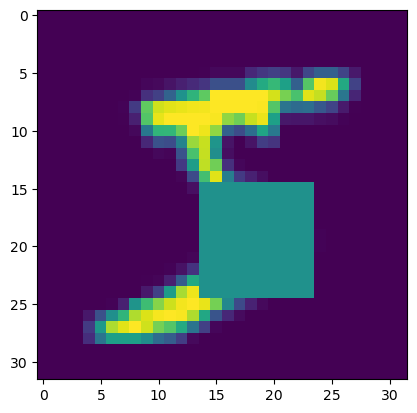

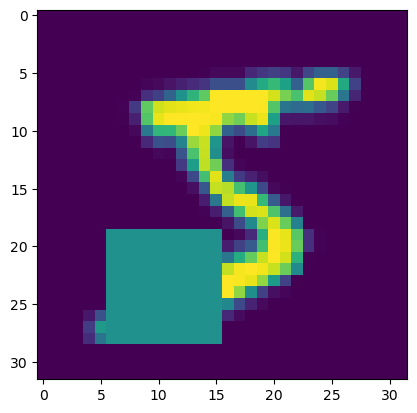

In [14]:
plt.imshow(mask_randomly(X_train[0:1])[0].reshape(32, 32))
plt.show()
plt.imshow(mask_randomly(X_train[0:1])[0].reshape(32, 32))
plt.show()


### 4. Fit model


2023-11-03 14:06:29.617609: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2023-11-03 14:06:29.669940: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-03 14:06:29.670546: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-03 14:06:29.670576: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-11-03 14:06:29.671091: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-03 14:06:29.671128: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-03 14:06:29.786445: I tensorflow/stream_executor/cuda/c

epoch = 1/100, d_loss=0.344, g_loss=0.203                                                                                                                      


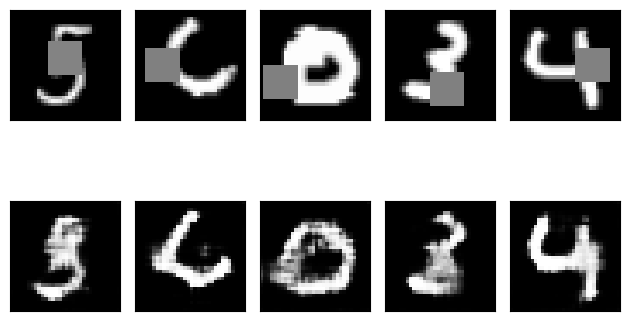

epoch = 2/100, d_loss=0.378, g_loss=0.209                                                                                                                      
epoch = 3/100, d_loss=0.319, g_loss=0.212                                                                                                                      
epoch = 4/100, d_loss=0.316, g_loss=0.205                                                                                                                      
epoch = 5/100, d_loss=0.250, g_loss=0.223                                                                                                                      
epoch = 6/100, d_loss=0.227, g_loss=0.319                                                                                                                      
epoch = 7/100, d_loss=0.154, g_loss=0.443                                                                                                                      
epoch = 8/100, d_loss=0.156, g_loss=0.40

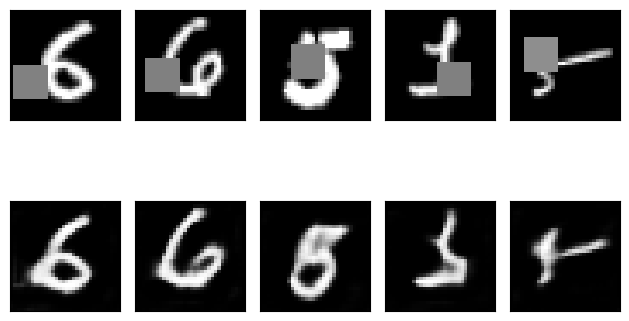

epoch = 12/100, d_loss=0.127, g_loss=0.224                                                                                                                       
epoch = 13/100, d_loss=0.148, g_loss=0.501                                                                                                                       
epoch = 14/100, d_loss=0.114, g_loss=0.294                                                                                                                      
epoch = 15/100, d_loss=0.097, g_loss=0.218                                                                                                                       
epoch = 16/100, d_loss=0.107, g_loss=0.195                                                                                                                       
epoch = 17/100, d_loss=0.105, g_loss=0.327                                                                                                                      
epoch = 18/100, d_loss=0.145, 

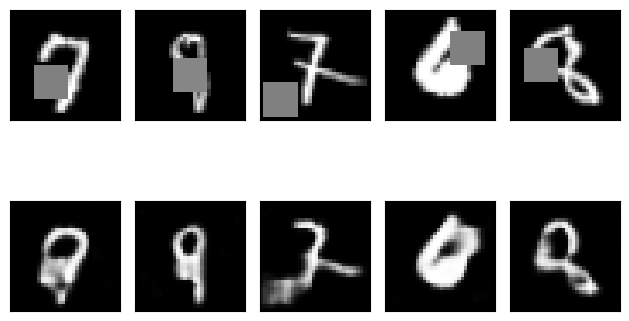

epoch = 22/100, d_loss=0.051, g_loss=0.209                                                                                                                      
epoch = 23/100, d_loss=0.037, g_loss=0.150                                                                                                                      
epoch = 24/100, d_loss=0.030, g_loss=0.123                                                                                                                      
epoch = 25/100, d_loss=0.026, g_loss=0.166                                                                                                                      
epoch = 26/100, d_loss=0.020, g_loss=0.174                                                                                                                      
epoch = 27/100, d_loss=0.018, g_loss=0.159                                                                                                                      
epoch = 28/100, d_loss=0.299, g_lo

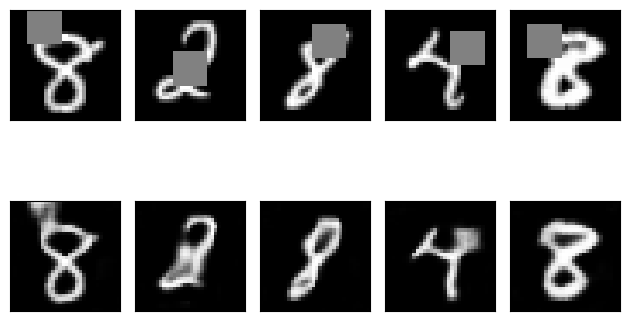

epoch = 32/100, d_loss=0.021, g_loss=0.182                                                                                                                      
epoch = 33/100, d_loss=0.013, g_loss=0.159                                                                                                                      
epoch = 34/100, d_loss=0.018, g_loss=0.139                                                                                                                      
epoch = 35/100, d_loss=0.017, g_loss=0.147                                                                                                                      
epoch = 36/100, d_loss=0.010, g_loss=0.177                                                                                                                      
epoch = 37/100, d_loss=0.104, g_loss=0.661                                                                                                                      
epoch = 38/100, d_loss=0.012, g_lo

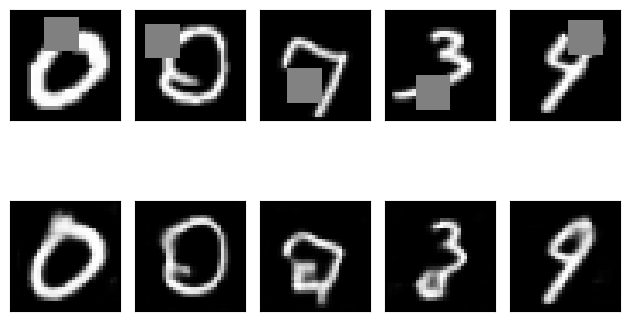

epoch = 42/100, d_loss=0.013, g_loss=0.209                                                                                                                      
epoch = 43/100, d_loss=0.009, g_loss=0.164                                                                                                                      
epoch = 44/100, d_loss=0.016, g_loss=0.140                                                                                                                      
epoch = 45/100, d_loss=0.008, g_loss=0.179                                                                                                                      
epoch = 46/100, d_loss=0.007, g_loss=0.168                                                                                                                      
epoch = 47/100, d_loss=0.014, g_loss=0.168                                                                                                                      
epoch = 48/100, d_loss=0.008, g_lo

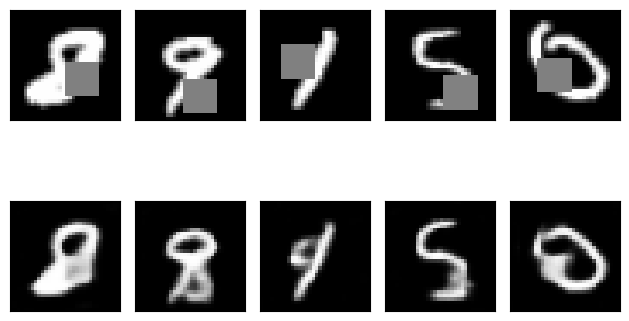

epoch = 52/100, d_loss=0.010, g_loss=0.194                                                                                                                      
epoch = 53/100, d_loss=0.008, g_loss=0.164                                                                                                                      
epoch = 54/100, d_loss=0.009, g_loss=0.152                                                                                                                      
epoch = 55/100, d_loss=0.006, g_loss=0.187                                                                                                                      
epoch = 56/100, d_loss=0.006, g_loss=0.161                                                                                                                      
epoch = 57/100, d_loss=0.010, g_loss=0.162                                                                                                                      
epoch = 58/100, d_loss=0.017, g_lo

2023-11-03 14:29:13.949344: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 59/100, d_loss=0.007, g_loss=0.200                                                                                                                      
epoch = 60/100, d_loss=0.009, g_loss=0.176                                                                                                                      
epoch = 61/100, d_loss=0.006, g_loss=0.209                                                                                                                      


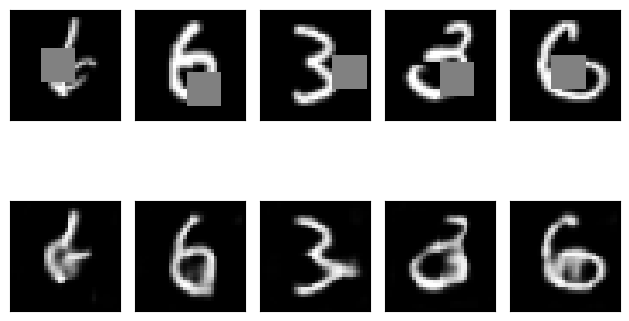

epoch = 62/100, d_loss=0.008, g_loss=0.189                                                                                                                      
epoch = 63/100, d_loss=0.005, g_loss=0.185                                                                                                                      
epoch = 64/100, d_loss=0.005, g_loss=0.174                                                                                                                      
epoch = 65/100, d_loss=0.005, g_loss=0.181                                                                                                                      
epoch = 66/100, d_loss=0.007, g_loss=0.170                                                                                                                      
epoch = 67/100, d_loss=0.006, g_loss=0.149                                                                                                                      
epoch = 68/100, d_loss=0.007, g_lo

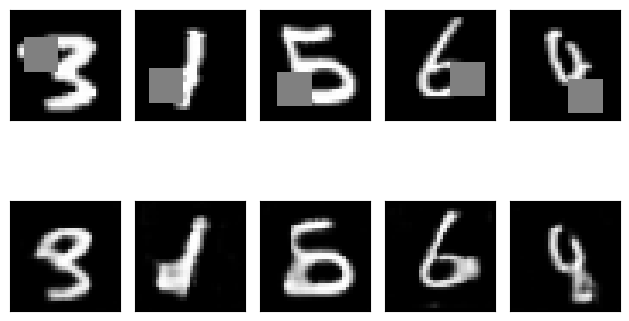

epoch = 72/100, d_loss=0.005, g_loss=0.167                                                                                                                      
epoch = 73/100, d_loss=0.222, g_loss=0.220                                                                                                                      
epoch = 74/100, d_loss=0.006, g_loss=0.215                                                                                                                      
epoch = 75/100, d_loss=0.006, g_loss=0.170                                                                                                                      
epoch = 76/100, d_loss=0.005, g_loss=0.169                                                                                                                      
epoch = 77/100, d_loss=0.005, g_loss=0.154                                                                                                                      
epoch = 78/100, d_loss=0.009, g_lo

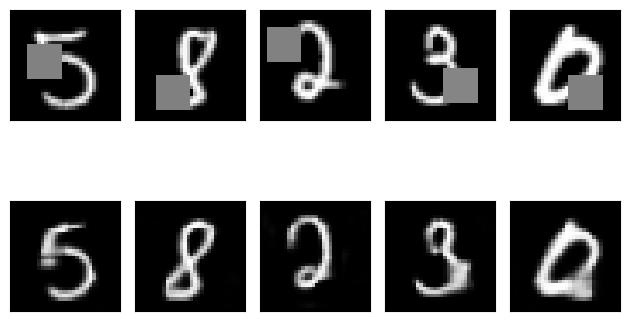

epoch = 82/100, d_loss=0.004, g_loss=0.204                                                                                                                      
epoch = 83/100, d_loss=0.012, g_loss=0.121                                                                                                                      
epoch = 84/100, d_loss=0.004, g_loss=0.173                                                                                                                      
epoch = 85/100, d_loss=0.005, g_loss=0.158                                                                                                                      
epoch = 86/100, d_loss=0.006, g_loss=0.180                                                                                                                      
epoch = 87/100, d_loss=0.011, g_loss=0.150                                                                                                                       
epoch = 88/100, d_loss=0.004, g_l

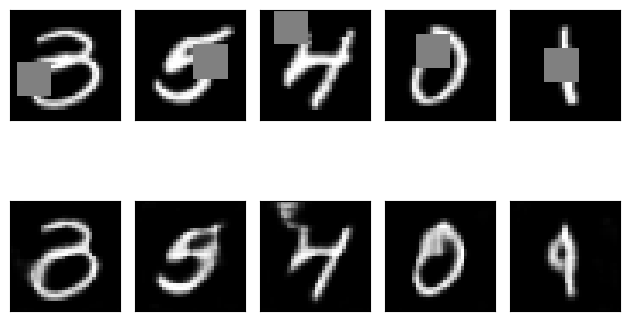

epoch = 92/100, d_loss=0.005, g_loss=0.177                                                                                                                      
epoch = 93/100, d_loss=0.005, g_loss=0.162                                                                                                                      
epoch = 94/100, d_loss=0.038, g_loss=0.061                                                                                                                      
epoch = 95/100, d_loss=0.053, g_loss=0.122                                                                                                                      
epoch = 96/100, d_loss=0.004, g_loss=0.170                                                                                                                      
epoch = 97/100, d_loss=0.004, g_loss=0.200                                                                                                                      
epoch = 98/100, d_loss=0.004, g_lo

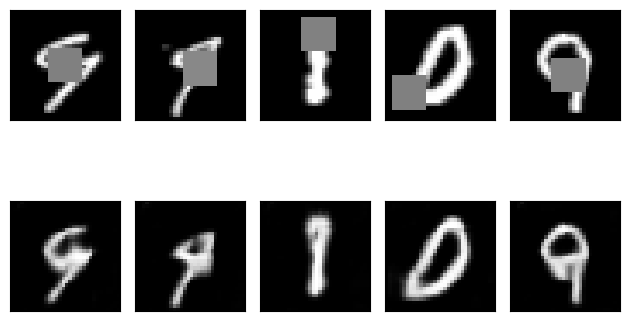

In [15]:
epochs = 100
batch_size = 64
smooth = 0.1

real = tf.ones((batch_size, 4, 4, 1))
real = real * (1 - smooth)
fake = tf.zeros((batch_size, 4, 4, 1))

fake_labels = tf.keras.utils.to_categorical(
    np.full((batch_size, 1), num_classes), num_classes=num_classes + 1
)

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):

        # Train Discriminator weights
        discriminator.trainable = True

        # Real samples
        img_real = X_train[i * batch_size : (i + 1) * batch_size]
        real_labels = y_train[i * batch_size : (i + 1) * batch_size]

        d_loss_real = discriminator.train_on_batch(
            x=img_real, y=[real, real_labels]
        )

        # Fake Samples
        masked_imgs = mask_randomly(img_real)
        gen_imgs = generator.predict_on_batch(masked_imgs)

        d_loss_fake = discriminator.train_on_batch(
            x=gen_imgs, y=[fake, fake_labels]
        )

        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator weights
        discriminator.trainable = False

        d_g_loss_batch = d_g.train_on_batch(x=img_real, y=real)

        print(
            "epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f"
            % (
                e + 1,
                epochs,
                i,
                len(X_train) // batch_size,
                d_loss_batch,
                d_g_loss_batch[0],
            ),
            100 * " ",
            end="\r",
        )

    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])

    print(
        "epoch = %d/%d, d_loss=%.3f, g_loss=%.3f"
        % (e + 1, epochs, d_loss[-1], d_g_loss[-1]),
        100 * " ",
    )

    if e % 10 == 0:
        samples = 5
        idx = np.random.randint(0, X_train.shape[0], samples)
        masked_imgs = mask_randomly(X_train[idx])
        x_fake = generator.predict_on_batch(masked_imgs)

        for k in range(samples):
            # plot masked
            plt.subplot(2, 5, k + 1)
            plt.imshow(masked_imgs[k].reshape(32, 32), cmap="gray")
            plt.xticks([])
            plt.yticks([])

            # plot recontructed
            plt.subplot(2, 5, k + 6)
            plt.imshow(x_fake[k].reshape(32, 32), cmap="gray")
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()


### 5. Evaluate model

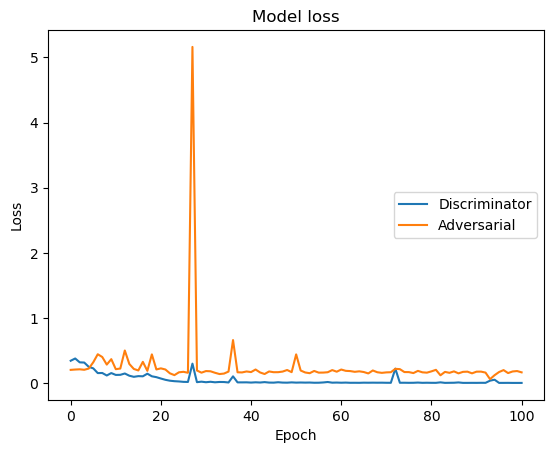

In [16]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()
